# Disaster classification

## -import libraries 

In [1]:
#for Data manipulation and visulization.
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#for NLP pre-processing
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#for Deep learning model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,GlobalAveragePooling1D,Embedding
from sklearn import metrics
from tensorflow.keras.optimizers import RMSprop
import random as rn
import pickle as pck
from sklearn.metrics import confusion_matrix

## 1-Load Dataset

In [2]:
df=pd.read_csv(r"C:\Users\user\Predcition disaster\train.csv")

## ----------------------------------------------------------------------------------------------------------------------------------

## 2- Check head and info of the data

In [4]:
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
df[df['target']==0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## ----------------------------------------------------------------------------------------------------------------------------------

## 3- Is there a missing data [how many and the percentage if there]?

In [7]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [176]:
df.keys()[2]

'location'

In [177]:
#find a better print format
for index,nulls in enumerate(df.isnull().sum()):
    per=nulls/df.shape[0]*100
    if(per==0.0):per="none"
    feature=df.keys()[index]
    print("-----------------------------------------------------------")
    print("In ",feature," there is ",per," of the data is missing")
    
    

-----------------------------------------------------------
In  id  there is  none  of the data is missing
-----------------------------------------------------------
In  keyword  there is  0.8012610009194797  of the data is missing
-----------------------------------------------------------
In  location  there is  33.27203467752528  of the data is missing
-----------------------------------------------------------
In  text  there is  none  of the data is missing
-----------------------------------------------------------
In  target  there is  none  of the data is missing


### Note : we found that location is the most feature of missing data.

## ----------------------------------------------------------------------------------------------------------------------------------

## 4- How many data in each class?

In [178]:
for i in df['target'].unique():
    print("we have",df[df['target']==i].shape[0],"of class",i)

we have 3271 of class 1
we have 4342 of class 0


In [179]:
df_0=df[df['target']==0].replace(np.nan,"unknown")
df_1=df[df['target']==1].replace(np.nan,"unknown")

## ----------------------------------------------------------------------------------------------------------------------------------

## 5- Get the top 15 locations of the data

In [76]:
freq_loc_0=dict()
for location in df_0['location'].unique():
    freq_loc_0[location]=0
for location in df_0['location']:
    freq_loc_0[location]+=1
   

In [77]:
freq_loc_1=dict()
for location in df_1['location'].dropna().unique():
    freq_loc_1[location]=0
for location in df_1['location'].dropna():
    freq_loc_1[location]+=1
   

In [78]:
loc_df_0=pd.DataFrame(freq_loc_0.values(),index=freq_loc_0.keys(),columns=["freq"]).sort_values('freq',ascending=False)
loc_df_1=pd.DataFrame(freq_loc_1.values(),index=freq_loc_1.keys(),columns=["freq"]).sort_values('freq',ascending=False)


In [79]:
keys_0=loc_df_0.index[1:16]
val_0=loc_df_0.iloc[1:16]['freq'].values
print(keys_0)
print(val_0)
keys_1=loc_df_1.index[1:16]
val_1=loc_df_1.iloc[1:16]['freq'].values
print(keys_1)
print(val_1)

Index(['New York', 'USA', 'London', 'United States', 'Los Angeles, CA',
       'Canada', 'Kenya', 'Everywhere', 'UK', 'Florida', 'United Kingdom',
       'California', 'NYC', 'Australia', 'Chicago, IL'],
      dtype='object')
[55 37 29 23 18 16 15 12 11 11 10 10 10  9  9]
Index(['USA', 'United States', 'Nigeria', 'India', 'Mumbai', 'New York', 'UK',
       'London', 'Washington, DC', 'Canada', 'Worldwide', 'Chicago, IL',
       'Washington, D.C.', 'Australia', 'Earth'],
      dtype='object')
[67 27 22 20 19 16 16 16 15 13 12  9  9  9  8]


In [80]:
loc_df_0.iloc[100:120]

,freq
Brazil,3
#FLIGHTCITY UK,3
Massachusetts,3
"Denver, CO",3
"Oregon, USA",3
"Sacramento, CA",3
Las Vegas,3
Rio de Janeiro,3
Colorado,3
NY,3


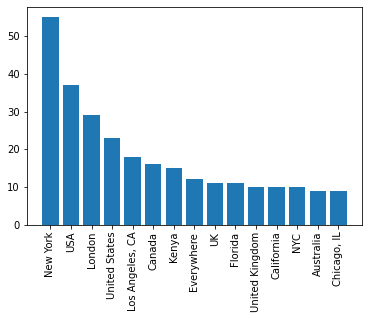

In [81]:
plt.figure()
plt.bar(keys_0,val_0)
plt.xticks(rotation=90)
plt.show()

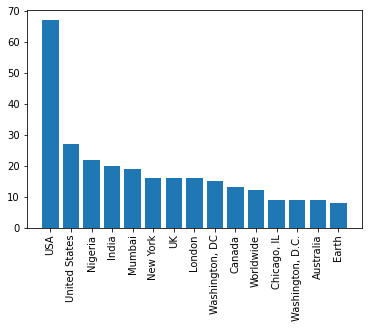

In [82]:
plt.figure()
plt.bar(keys_1,val_1)
plt.xticks(rotation=90)
plt.show()

### We found that there is multiple location are in the same location like NYC ,California , USA , united states and Chicago ,   so we will try to make location rely on countries

## ----------------------------------------------------------------------------------------------------------------------------------

## 6- Get the top 15 keywords of the data

In [83]:
freq_key_0=dict()
for kw in df_0['keyword'].unique():
    freq_key_0[kw]=0
for kw in df_0['keyword']:
    freq_key_0[kw]+=1
   

In [84]:
freq_key_1=dict()
for kw in df_1['keyword'].dropna().unique():
    freq_key_1[kw]=0
for kw in df_1['keyword'].dropna():
    freq_key_1[kw]+=1

In [85]:
kw_df_0=pd.DataFrame(freq_key_0.values(),index=freq_key_0.keys(),columns=["freq"]).sort_values('freq',ascending=False)
kw_df_1=pd.DataFrame(freq_key_1.values(),index=freq_key_1.keys(),columns=["freq"]).sort_values('freq',ascending=False)

In [86]:
kw_df_0.iloc[0:16]

,freq
body%20bags,40
harm,37
armageddon,37
deluge,36
ruin,36
wrecked,36
twister,35
explode,35
fear,35
siren,35


In [87]:
kw_df_1.iloc[0:16]

,freq
unknown,42
wreckage,39
outbreak,39
derailment,39
typhoon,37
debris,37
oil%20spill,37
rescuers,32
suicide%20bombing,32
suicide%20bomb,32


In [88]:
keys_0=kw_df_0.index[1:16]
val_0=kw_df_0.iloc[1:16]['freq'].values
print(keys_0)
print(val_0)
keys_1=kw_df_1.index[1:16]
val_1=kw_df_1.iloc[1:16]['freq'].values
print(keys_1)
print(val_1)

Index(['harm', 'armageddon', 'deluge', 'ruin', 'wrecked', 'twister', 'explode',
       'fear', 'siren', 'screaming', 'aftershock', 'panic', 'blizzard',
       'blazing', 'blaze'],
      dtype='object')
[37 37 36 36 36 35 35 35 35 34 34 34 33 33 33]
Index(['wreckage', 'outbreak', 'derailment', 'typhoon', 'debris',
       'oil%20spill', 'rescuers', 'suicide%20bombing', 'suicide%20bomb',
       'evacuated', 'razed', 'nuclear%20disaster', 'earthquake',
       'suicide%20bomber', 'airplane%20accident'],
      dtype='object')
[39 39 39 37 37 37 32 32 32 32 31 31 30 30 30]


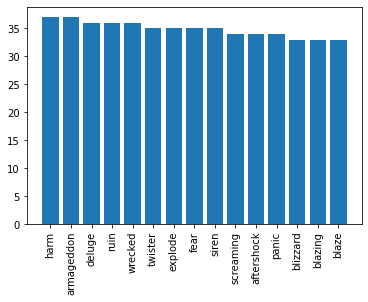

In [89]:
plt.figure()
plt.bar(keys_0,val_0)
plt.xticks(rotation=90)
plt.show()

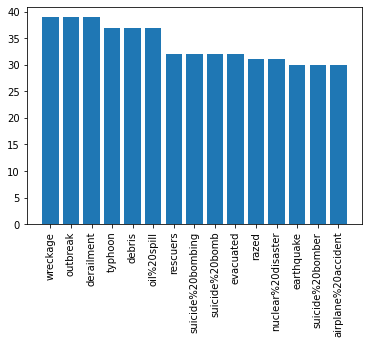

In [90]:
plt.figure()
plt.bar(keys_1,val_1)
plt.xticks(rotation=90)
plt.show()

## ----------------------------------------------------------------------------------------------------------------------------------

## 7- What are the most common words?

In [91]:
stop_words=stopwords.words('english')

In [92]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [93]:
freq_tweets_words_0={}
for tweet in df_0['text']:
    for word in tweet.split():
        if(word.lower() not in stop_words):
            freq_tweets_words_0[word.lower()]=0
for tweet in df_0['text']:
    for word in tweet.split():
         if(word.lower() not in stop_words):
            freq_tweets_words_0[word.lower()]+=1      
        

In [94]:
freq_tweets_words_1={}
for tweet in df_1['text']:
    for word in tweet.split():
        if(word.lower() not in stop_words):
            freq_tweets_words_1[word.lower()]=0  
for tweet in df_1['text']:
    for word in tweet.split():
        if(word.lower() not in stop_words):
            freq_tweets_words_1[word.lower()]+=1  

In [95]:
words_df_0=pd.DataFrame(freq_tweets_words_0.values(),index=freq_tweets_words_0.keys(),columns=["freq"]).sort_values('freq',ascending=False)

In [96]:
words_df_1=pd.DataFrame(freq_tweets_words_1.values(),index=freq_tweets_words_1.keys(),columns=["freq"]).sort_values('freq',ascending=False)

In [97]:
words_df_0.head(15)

,freq
-,374
like,250
i'm,195
&amp;,190
??,183
new,163
get,161
one,116
body,106
via,97


In [98]:
words_df_1.head(15)

,freq
-,389
fire,151
via,117
...,106
&amp;,105
suicide,103
disaster,97
police,94
people,93
killed,92


In [99]:
keys_words_0=words_df_0.index
val_words_0=words_df_0['freq'].values
print(keys_words_0[0:16])
print(val_words_0[0:16])
keys_words_1=words_df_1.index
val_words_1=words_df_1['freq'].values
print(keys_words_1)
print(val_words_1)

Index(['-', 'like', 'i'm', '&amp;', '??', 'new', 'get', 'one', 'body', 'via',
       'would', '|', 'love', 'got', 'full', 'people'],
      dtype='object')
[374 250 195 190 183 163 161 116 106  97  94  91  85  82  81  81]
Index(['-', 'fire', 'via', '...', '&amp;', 'suicide', 'disaster', 'police',
       'people', 'killed',
       ...
       'here.', 'newly', 'maple', 'drowning.', 'saves', 'drowning:',
       'nine-year-old', 'maine', 'dove', 'http://t.co/ymy4rskq3d'],
      dtype='object', length=14161)
[389 151 117 ...   1   1   1]


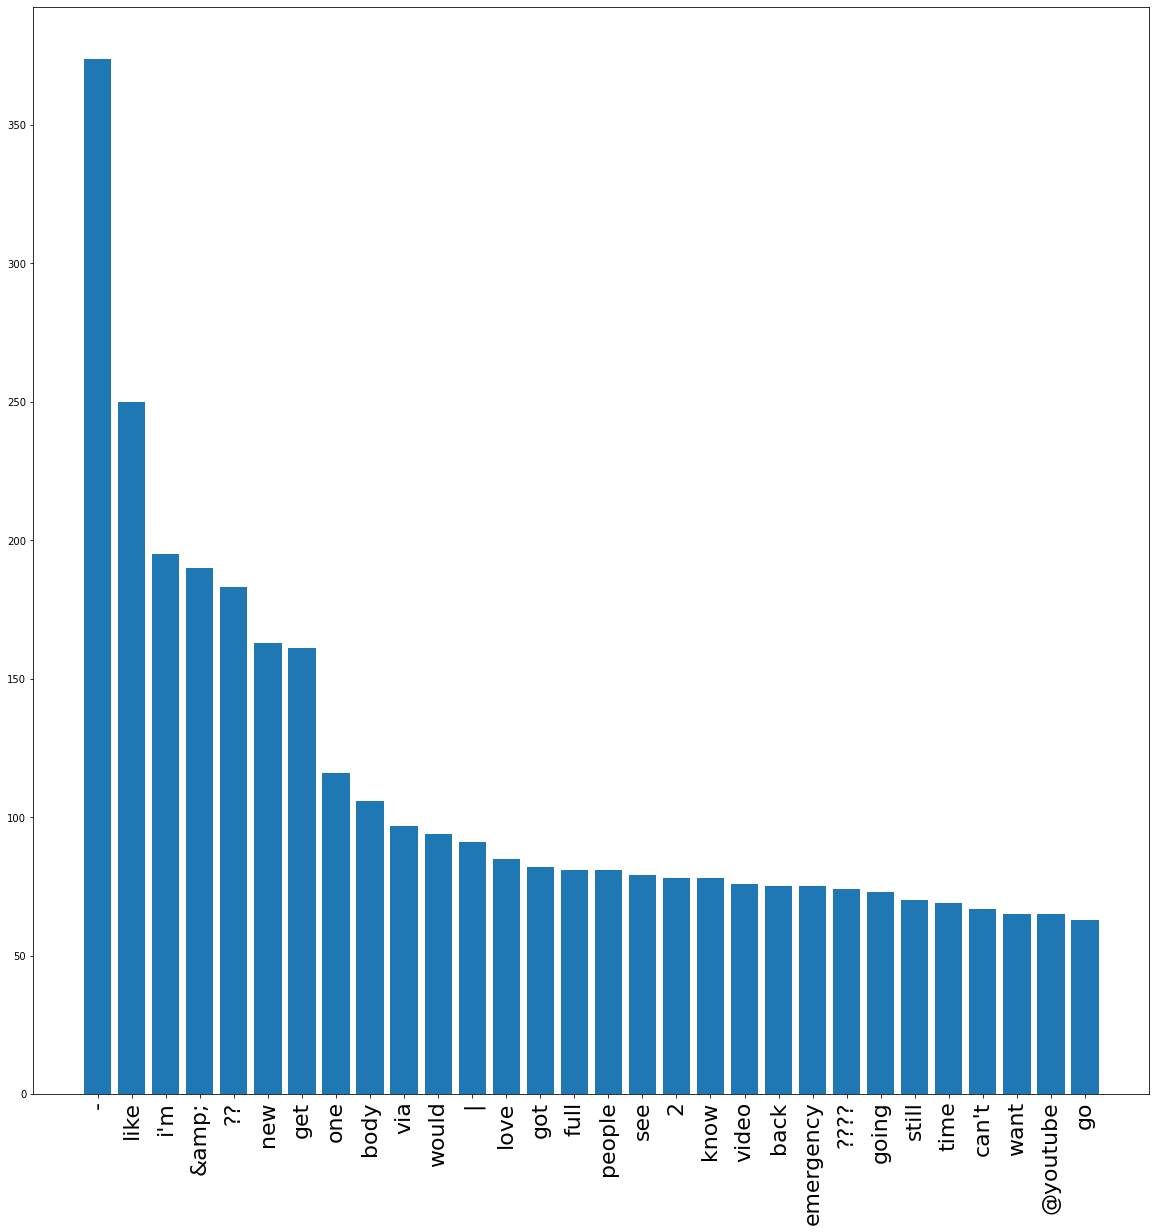

In [100]:
plt.figure(figsize=(20,20))
plt.bar(keys_words_0[0:30],val_words_0[0:30])
plt.xticks(rotation=90,fontsize=22)
plt.show()

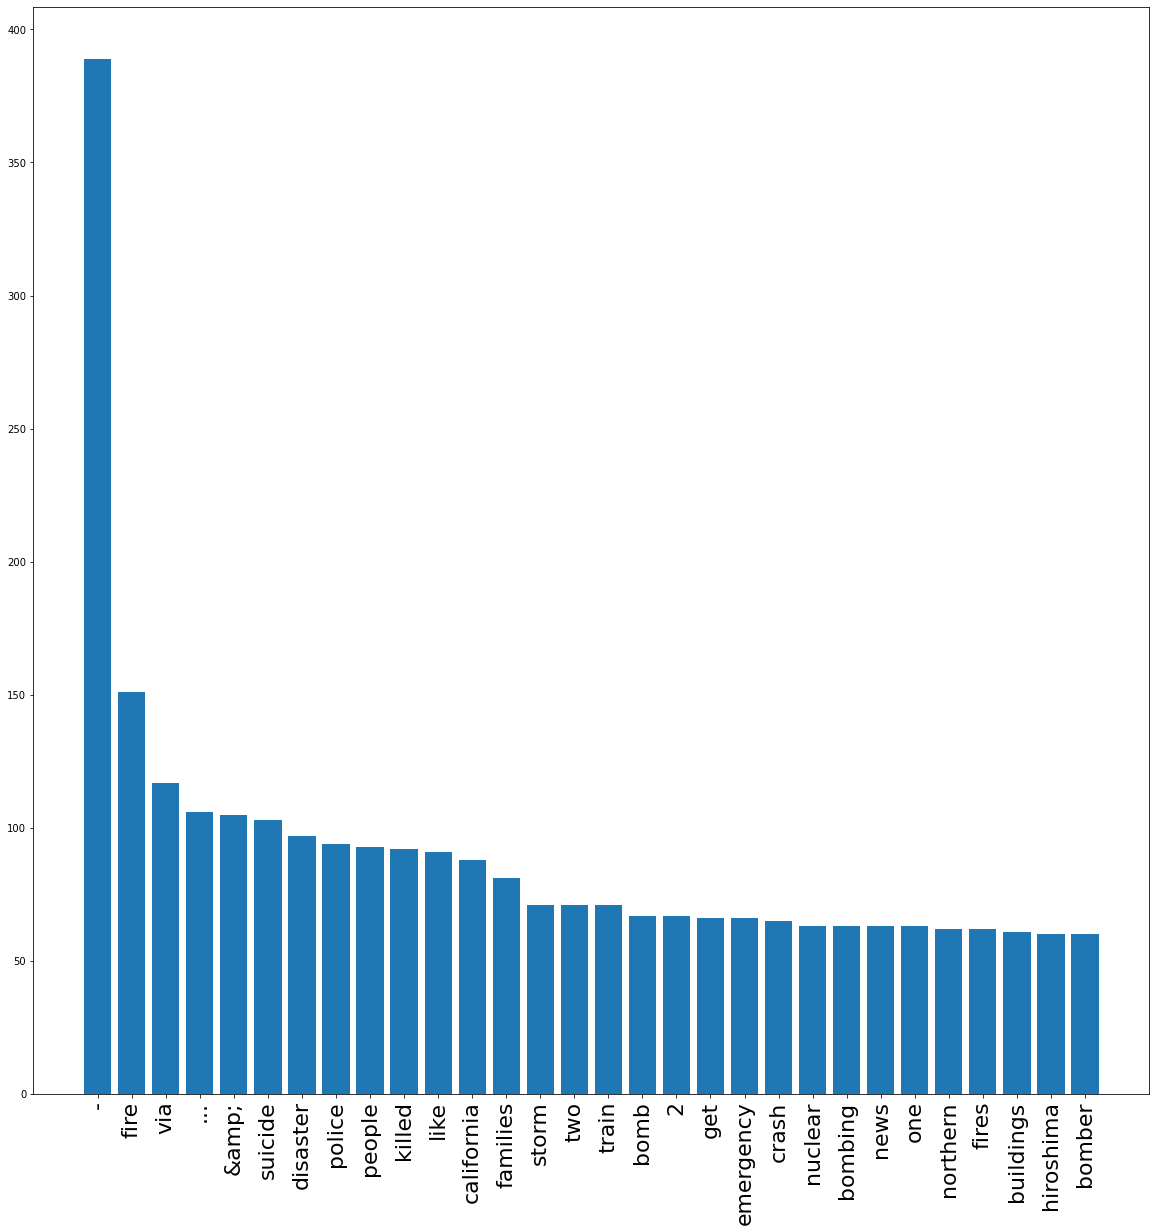

In [101]:
plt.figure(figsize=(20,20))
plt.bar(keys_words_1[0:30],val_words_1[0:30])
plt.xticks(rotation=90,fontsize=22)
plt.show()

## ----------------------------------------------------------------------------------------------------------------------------------

## 8- What are the most common stop words?

In [102]:
stop_words=stopwords.words('english')

In [103]:
freq_tweets_words_0={}
for tweet in df_0['text']:
    for word in tweet.split():
        if(word.lower() in stop_words):
            freq_tweets_words_0[word.lower()]=0
for tweet in df_0['text']:
    for word in tweet.split():
        if(word.lower() in stop_words):
            freq_tweets_words_0[word.lower()]+=1  

In [104]:
freq_tweets_words_1={}
for tweet in df_1['text']:
    for word in tweet.split():
        if(word.lower() in stop_words):
            freq_tweets_words_1[word.lower()]=1
for tweet in df_1['text']:
    for word in tweet.split():
        if(word.lower() in stop_words):
            freq_tweets_words_1[word.lower()]+=1  

In [105]:
words_df_0=pd.DataFrame(freq_tweets_words_0.values(),index=freq_tweets_words_0.keys(),columns=["freq"]).sort_values('freq',ascending=False)

In [106]:
words_df_1=pd.DataFrame(freq_tweets_words_1.values(),index=freq_tweets_words_1.keys(),columns=["freq"]).sort_values('freq',ascending=False)

In [107]:
words_df_0.head(15)

,freq
the,1877
a,1238
to,1181
i,1052
and,911
of,895
in,805
you,625
is,586
my,541


In [108]:
words_df_1.head(15)

,freq
the,1331
in,1145
of,920
a,898
to,754
and,495
on,411
for,395
is,345
at,304


In [109]:
keys_words_0=words_df_0.index
val_words_0=words_df_0['freq'].values
print(keys_words_0[0:16])
print(val_words_0[0:16])
keys_words_1=words_df_1.index
val_words_1=words_df_1['freq'].values
print(keys_words_1)
print(val_words_1)

Index(['the', 'a', 'to', 'i', 'and', 'of', 'in', 'you', 'is', 'my', 'for',
       'on', 'with', 'that', 'it', 'this'],
      dtype='object')
[1877 1238 1181 1052  911  895  805  625  586  541  486  424  374  357
  341  286]
Index(['the', 'in', 'of', 'a', 'to', 'and', 'on', 'for', 'is', 'at',
       ...
       'itself', 'you've', 'yourselves', 'shouldn't', 'couldn't', 'myself',
       'below', 't', 'won', 'o'],
      dtype='object', length=141)
[1331 1145  920  898  754  495  411  395  345  304  285  275  244  189
  182  182  178  168  167  166  164  141  131  124  122  122  115  114
  113  105  101  100   96   94   94   91   86   85   78   78   76   76
   75   73   69   66   63   62   61   61   59   58   58   55   53   53
   51   47   47   47   47   46   43   43   40   40   38   38   38   37
   34   33   32   32   29   28   26   26   24   24   23   22   22   22
   22   21   20   20   19   19   19   17   17   16   16   16   15   15
   15   12   12   12   11   10    9    9    8    8    8

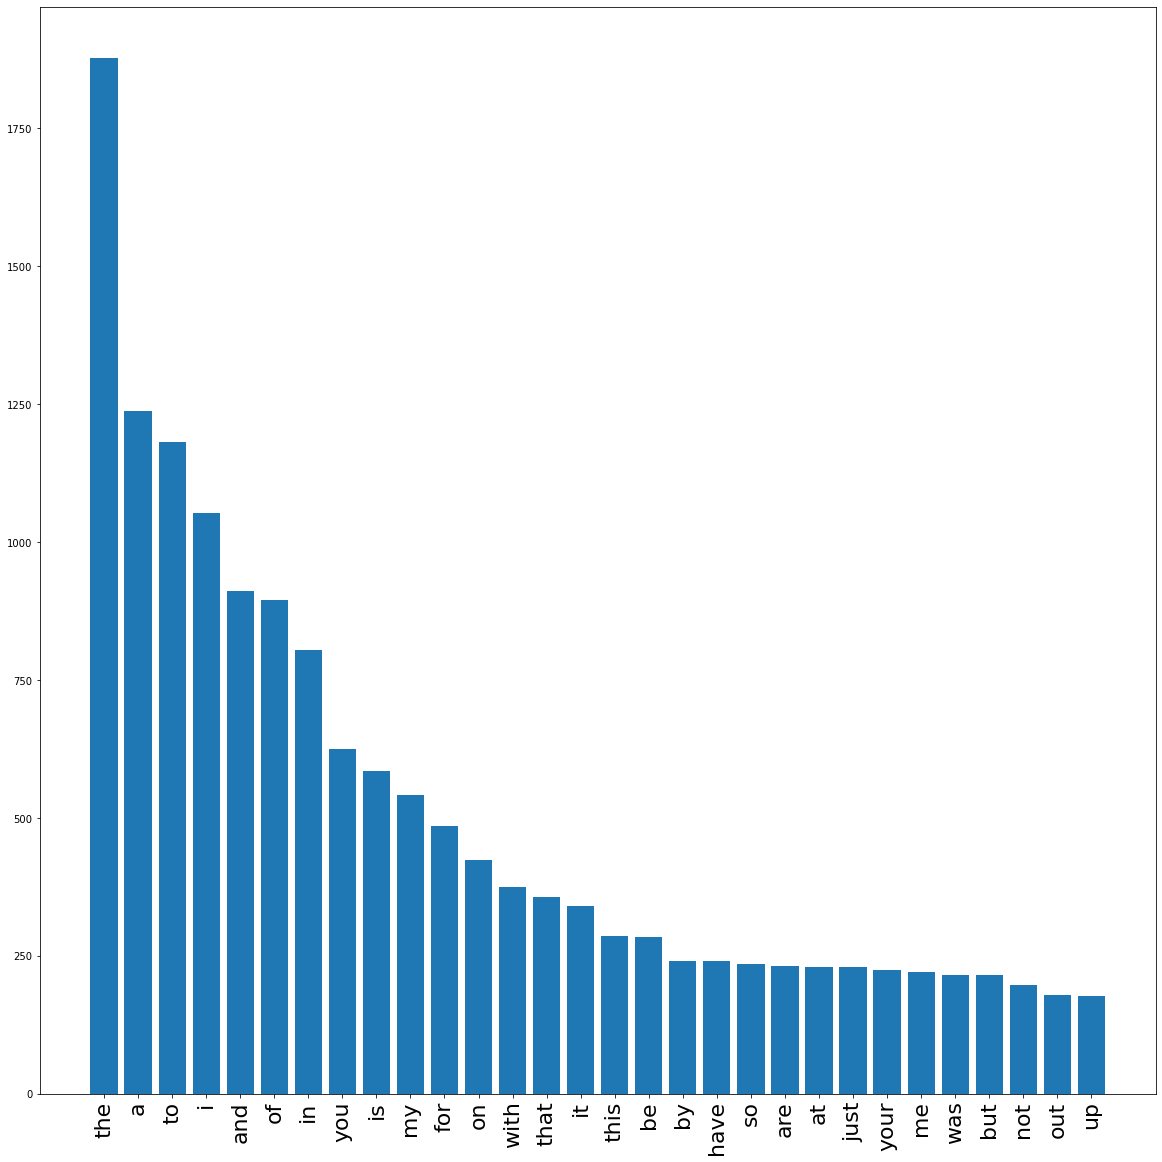

In [110]:
plt.figure(figsize=(20,20))
plt.bar(keys_words_0[0:30],val_words_0[0:30])
plt.xticks(rotation=90,fontsize=22)
plt.show()

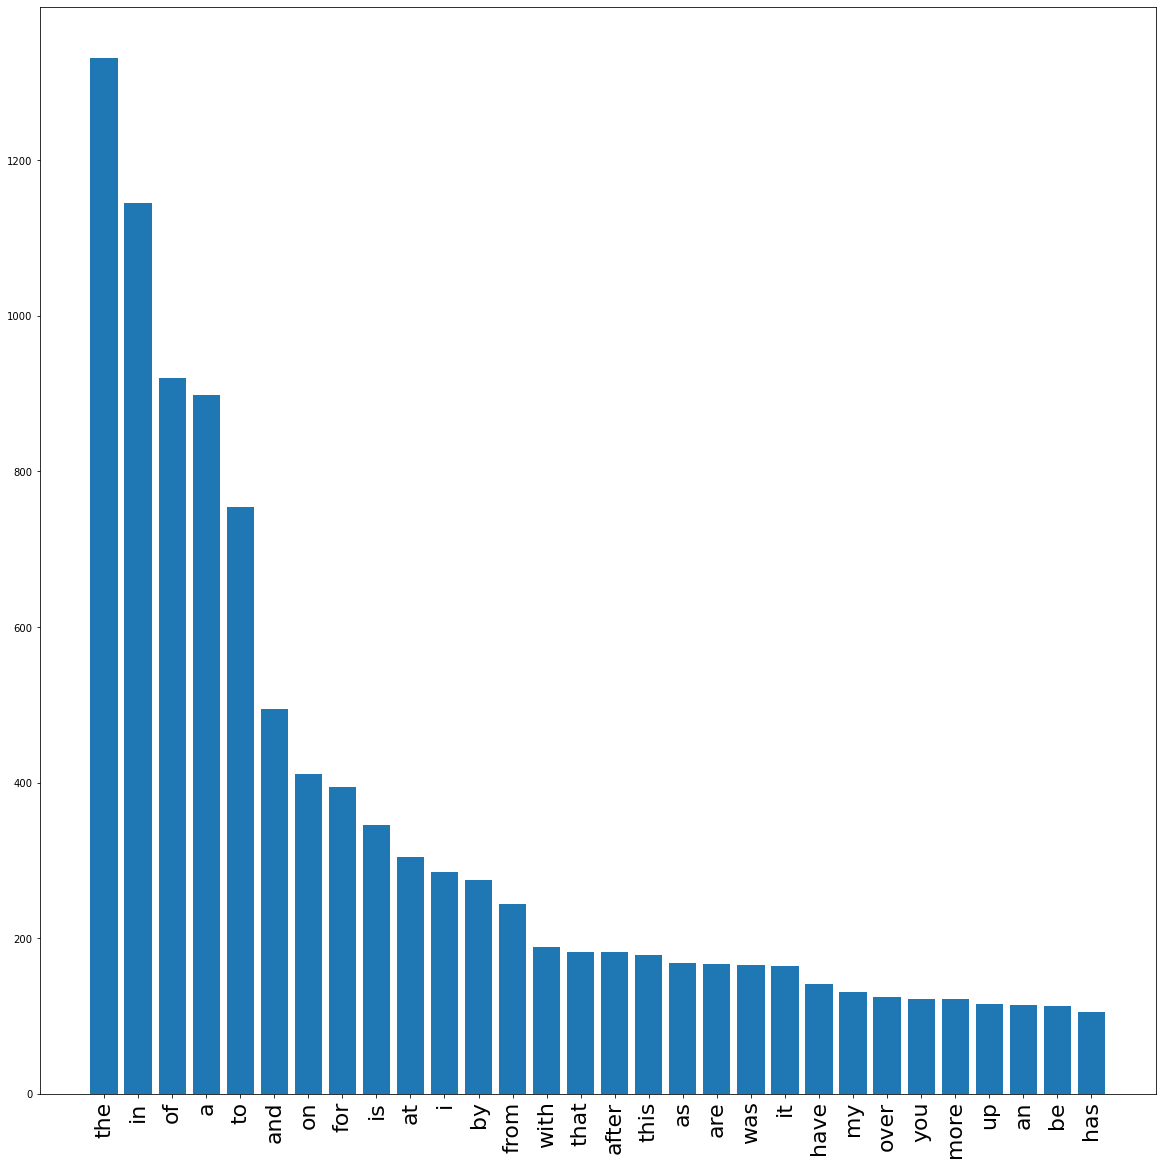

In [111]:
plt.figure(figsize=(20,20))
plt.bar(keys_words_1[0:30],val_words_1[0:30])
plt.xticks(rotation=90,fontsize=22)
plt.show()

## ----------------------------------------------------------------------------------------------------------------------------------

## 9- Use nlp to prepare dataset [tokenization, pad sequence, etc.] 

### a-to check if there are punctuations

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [3]:
s=set()
for text in df['text']:
    for i in re.findall("[!#$%&()*+,-./:;<=>?@[\]^_`{|}~]",text):
        s.add(i)
print(s)        

{'|', ']', '%', '^', '$', '(', '{', '.', '&', '+', '>', '!', '/', '_', '}', ',', ';', '[', ')', '~', '*', '`', '?', ':', '@', '=', '#', '-'}


In [4]:
stop_words=stopwords.words('english')

In [5]:
stemmer=PorterStemmer()
clean_comments=[]

for text in df['text']:
    
    x=re.sub('"',"",text)
    x=re.sub("[!#$%&()*+,-./:;<=>?@[\]^`{|}~]","",x)
    x=re.sub('[0-9]',"",x)
    x=re.sub('\d{1}/\d{1}/\d{4}',"",x)
    x=re.sub('\d{2}:\d{2}',"",x)
    x=re.sub('pm:',"",x)
    x=re.sub(',',"",x)
    x=re.sub("^\s+","",x) #to remove extra spaces 
    x=re.sub("\s+$","",x) #to remove extra spaces
    x=re.sub("#","",x) #to remove hash in hastags
    x=re.sub("@","",x) #to remove @ in mentions 
    x=re.sub(r"http\S+", "", x) #to remove links
    x=re.sub("(\w+'\w+)", "", x) #to remove words like [i'm ,you've] with apostrophe
    clean_text=[]
    
    for word in x.split():
        if word.lower() not in stop_words:
            clean_text.append(stemmer.stem(word))     

    clean_comments.append(clean_text)

In [6]:
wordset=set()
maxlen=0
for sentence in clean_comments:
    if(len(sentence)>maxlen):
        maxlen=len(sentence)
    for word in sentence:
        wordset.add(word)
print(maxlen)
print(len(wordset))
    

23
14535


In [8]:
clean_comments[0:10]

[['deed', 'reason', 'earthquak', 'may', 'allah', 'forgiv', 'us'],
 ['forest', 'fire', 'near', 'la', 'rong', 'sask', 'canada'],
 ['resid',
  'ask',
  "'shelter",
  "place'",
  'notifi',
  'offic',
  'evacu',
  'shelter',
  'place',
  'order',
  'expect'],
 ['peopl', 'receiv', 'wildfir', 'evacu', 'order', 'california'],
 ['got',
  'sent',
  'photo',
  'rubi',
  'alaska',
  'smoke',
  'wildfir',
  'pour',
  'school'],
 ['rockyfir',
  'updat',
  'california',
  'hwi',
  'close',
  'direct',
  'due',
  'lake',
  'counti',
  'fire',
  'cafir',
  'wildfir'],
 ['flood',
  'disast',
  'heavi',
  'rain',
  'caus',
  'flash',
  'flood',
  'street',
  'manit',
  'colorado',
  'spring',
  'area'],
 ['top', 'hill', 'see', 'fire', 'wood'],
 ['emerg', 'evacu', 'happen', 'build', 'across', 'street'],
 ['afraid', 'tornado', 'come', 'area']]

In [22]:
df['text']=clean_comments

In [23]:
tokenizer = Tokenizer(num_words = 8000 ,split=' ')
tokenizer.fit_on_texts(df['text'].values) # to fit the data
x = tokenizer.texts_to_sequences(df['text'].values) # to change words to numbers  
X= pad_sequences(x,maxlen=23,padding='post',value=0)

In [24]:
X

array([[3690,  450,  206, ...,    0,    0,    0],
       [ 136,    2,  181, ...,    0,    0,    0],
       [1350,  506, 5349, ...,    0,    0,    0],
       ...,
       [3463,  445, 1340, ...,    0,    0,    0],
       [  27,  171, 2659, ...,    0,    0,    0],
       [ 162,   28,  408, ...,    0,    0,    0]])

In [66]:
dfnew=pd.DataFrame(X)

In [72]:
dftrail=pd.concat([dfnew,df.drop(['text','id'],axis=1).replace(np.nan,"unknown")],axis=1)

In [73]:
le=LabelEncoder()
dftrail['keyword']=le.fit_transform(df['keyword'])
dftrail['location']=le.fit_transform(df['location'])

In [87]:
X=dftrail.drop(['target','location'],axis=1)
y=dftrail['target']

In [88]:
dftrail

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,keyword,location,target
0,3690,450,206,85,1349,2893,15,0,0,0,...,0,0,0,0,0,0,0,221,3341,1
1,136,2,181,481,5347,5348,1174,0,0,0,...,0,0,0,0,0,0,0,221,3341,1
2,1350,506,5349,5350,5351,216,32,2077,389,325,...,0,0,0,0,0,0,0,221,3341,1
3,10,2410,100,32,325,45,0,0,0,0,...,0,0,0,0,0,0,0,221,3341,1
4,50,1027,140,5352,1817,191,100,2411,127,0,...,0,0,0,0,0,0,0,221,3341,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,67,663,1007,520,290,44,543,28,0,0,...,0,0,0,0,0,0,0,221,3341,1
7609,5326,5327,555,249,2,45,89,146,320,168,...,0,0,0,0,0,0,0,221,3341,1
7610,3463,445,1340,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,221,3341,1
7611,27,171,2659,112,52,255,4249,2659,1635,1081,...,0,0,0,0,0,0,0,221,3341,1


## ----------------------------------------------------------------------------------------------------------------------------------

## 10- Prepare train, test sets

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2002)

## ----------------------------------------------------------------------------------------------------------------------------------

## 11- Train your LSTM structure

In [142]:
model=Sequential()
model.add(Embedding(17651,20,input_length=24))

model.add(LSTM(250))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 24, 20)            353020    
                                                                 
 lstm_13 (LSTM)              (None, 250)               271000    
                                                                 
 dropout_59 (Dropout)        (None, 250)               0         
                                                                 
 dense_59 (Dense)            (None, 32)                8032      
                                                                 
 dropout_60 (Dropout)        (None, 32)                0         
                                                                 
 dense_60 (Dense)            (None, 64)                2112      
                                                                 
 dropout_61 (Dropout)        (None, 64)              

In [143]:
model.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [144]:
history =model.fit(X_train,y_train, batch_size=300,epochs=8,validation_data=(X_test, y_test),shuffle=1)

Epoch 1/8
21/21 [==============================] - 5s 146ms/step - loss: 0.6821 - accuracy: 0.5722 - val_loss: 0.6704 - val_accuracy: 0.5791
Epoch 2/8
21/21 [==============================] - 3s 129ms/step - loss: 0.6004 - accuracy: 0.6309 - val_loss: 0.5770 - val_accuracy: 0.7406
Epoch 3/8
21/21 [==============================] - 3s 137ms/step - loss: 0.5389 - accuracy: 0.8064 - val_loss: 0.5367 - val_accuracy: 0.7630
Epoch 4/8
21/21 [==============================] - 3s 156ms/step - loss: 0.4578 - accuracy: 0.8315 - val_loss: 0.4742 - val_accuracy: 0.7794
Epoch 5/8
21/21 [==============================] - 3s 152ms/step - loss: 0.3633 - accuracy: 0.8642 - val_loss: 0.4694 - val_accuracy: 0.7886
Epoch 6/8
21/21 [==============================] - 3s 148ms/step - loss: 0.3282 - accuracy: 0.8862 - val_loss: 0.4823 - val_accuracy: 0.7846
Epoch 7/8
21/21 [==============================] - 3s 148ms/step - loss: 0.2711 - accuracy: 0.9077 - val_loss: 0.6496 - val_accuracy: 0.7774
Epoch 8/8
21/

## ----------------------------------------------------------------------------------------------------------------------------------

## 12- Evaluate the model and make predictions

In [122]:
df_test=pd.concat([X_test,y_test],axis=1)

In [123]:
df_test['pred']=model.predict(X_test)

In [134]:
df_test[['target','pred']].sample(n=10) #to display 10 samples with there predictions  

,target,pred
781,0,0.045541
1595,0,0.037397
902,0,0.052373
1860,0,0.036241
2652,0,0.036368
4727,0,0.026704
7271,1,0.967878
4992,0,0.031572
1200,0,0.142661
1557,1,0.932900


## ---------------------------------------------------------------------------------------------------------------------------------- 

## 13- Evaluate the results with charts of acc and loss


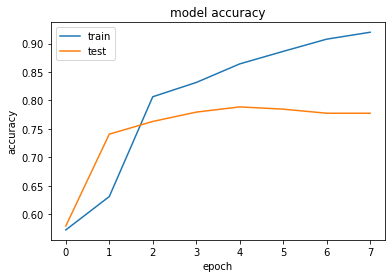

In [145]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

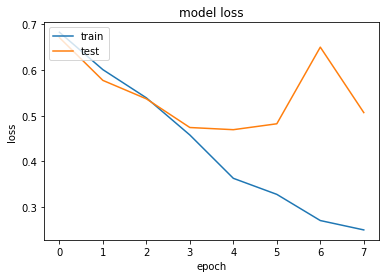

In [146]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [148]:
train_accuracy = (metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
train_accuracy

93.97372742200328

In [162]:
print('Accuracy  is  : ', (metrics.accuracy_score(df_test['target'], round(df_test['pred']))))
print('Recall  is    : ', (metrics.recall_score(df_test['target'], round(df_test['pred']))))
print('Precision  is : ', (metrics.precision_score(df_test['target'], round(df_test['pred']))))

Accuracy  is  :  0.7662508207485227
Recall  is    :  0.6942277691107644
Precision  is :  0.7355371900826446


In [167]:
conm = confusion_matrix(df_test['target'],round(df_test['pred']))
conm

array([[722, 160],
       [196, 445]], dtype=int64)

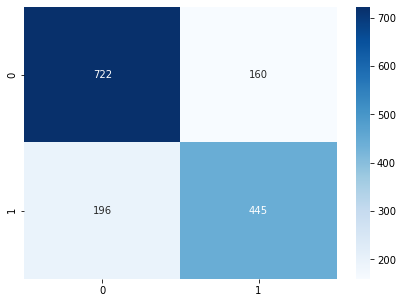

In [176]:
plt.figure(figsize=(7, 5))
sns.heatmap(conm,annot=True, fmt='', cmap='Blues')
plt.show()

## ----------------------------------------------------------------------------------------------------------------------------------

## 14- Save your model

In [147]:
filename="LSTM.sav"
pck.dump(model,open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://d355c459-c15f-4c10-8e78-769c31d7bbd2/assets


INFO:tensorflow:Assets written to: ram://d355c459-c15f-4c10-8e78-769c31d7bbd2/assets
